In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Ajusta el nombre del archivo
df = pd.read_csv("datos.csv")

# Vista general de las primeras filas
print("Primeras filas del dataset:")
display(df.head())

# Informacion general del dataset
print("\nInformación del dataset:")
df.info()

# Estadisticas descriptivas 
print("\nEstadísticas descriptivas:")
display(df.describe())

# Revision de valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Revision de duplicados
print(f"\nCantidad de registros duplicados: {df.duplicated().sum()}")


# Limpieza básica
df = df.drop_duplicates()
for c in ["Age","Annual Income","Spending Score"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")




Primeras filas del dataset:


,Customer ID,Age,Gender,Annual Income,Spending Score
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,30,Male,151479,89
1,1770b26f-493f-46b6-837f-4237fb5a314e,58,Female,185088,95
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,62,Female,70912,76
3,9795712a-ad19-47bf-8886-4f997d6046e3,23,Male,55460,57
4,64139426-2226-4cd6-bf09-91bce4b4db5e,24,Male,153752,76



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     15079 non-null  object
 1   Age             15079 non-null  int64 
 2   Gender          15079 non-null  object
 3   Annual Income   15079 non-null  int64 
 4   Spending Score  15079 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 589.2+ KB

Estadísticas descriptivas:


,Age,Annual Income,Spending Score
count,15079.000000,15079.000000,15079.000000
mean,54.191591,109742.880562,50.591617
std,21.119207,52249.425866,28.726977
min,18.000000,20022.000000,1.000000
25%,36.000000,64141.000000,26.000000
50%,54.000000,109190.000000,51.000000
75%,72.000000,155008.000000,75.000000
max,90.000000,199974.000000,100.000000



Valores nulos por columna:
Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64

Cantidad de registros duplicados: 0


In [ ]:
#paso 2: Limpieza de datos

# --- Eliminación de duplicados ---
df = df.drop_duplicates()
print(f"Registros después de eliminar duplicados: {df.shape[0]}")

# --- Manejo de valores nulos ---
print("Valores nulos por columna antes de limpiar:")
print(df.isnull().sum())

# Opción 2: imputar (ejemplo: con la media en columnas numéricas)
df = df.fillna(df.mean(numeric_only=True))

print("\nValores nulos después de limpiar:")
print(df.isnull().sum())

Registros después de eliminar duplicados: 15079
Valores nulos por columna antes de limpiar:
Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64

Valores nulos después de limpiar:
Customer ID       0
Age               0
Gender            0
Annual Income     0
Spending Score    0
dtype: int64


In [13]:

# Seleccionar solo columnas numéricas relevantes
X = df.select_dtypes(include=[np.number])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Tamaño de los datos escalados:", X_scaled.shape)

Tamaño de los datos escalados: (15079, 3)


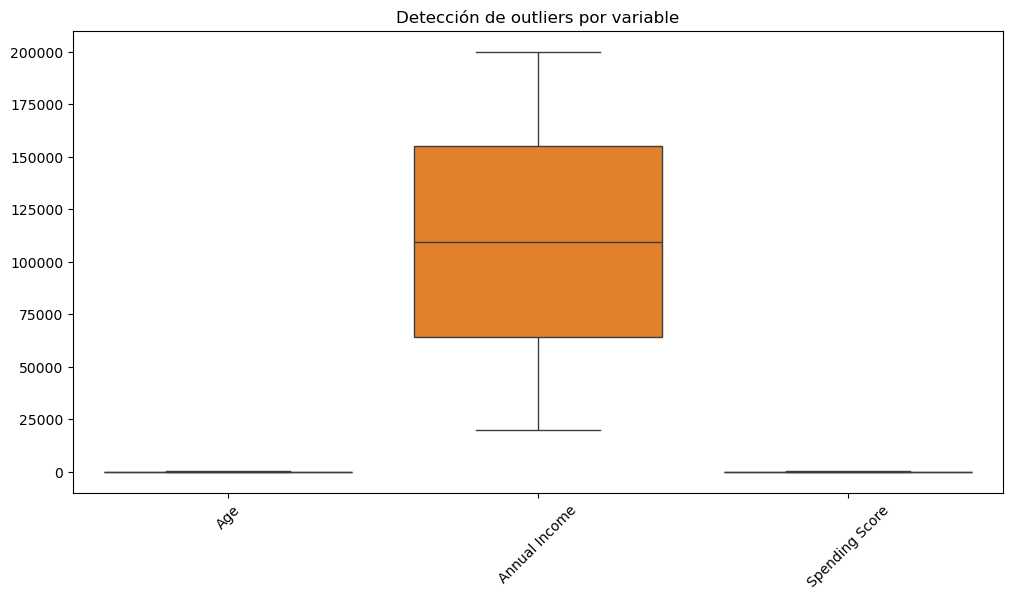

Cantidad de posibles outliers: 0


In [14]:
# Detección gráfica con boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Detección de outliers por variable")
plt.show()

# Detección numérica usando z-score
from scipy import stats

z_scores = np.abs(stats.zscore(X))
outliers = (z_scores > 3).sum(axis=1)  # filas con valores fuera de rango
print(f"Cantidad de posibles outliers: {(outliers > 0).sum()}") 

In [ ]:
# Selección de variables
vars_kmeans = ["Age","Annual Income","Spending Score"]
X = df[vars_kmeans].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

,k,SSE_inercia,Silhouette
4,6,14885.534788,0.289854
7,9,10610.282825,0.288545
5,7,13034.533098,0.282047
6,8,11315.075024,0.279877
8,10,10048.231508,0.276424
3,5,18010.372652,0.266842
2,4,21463.203946,0.264149
0,2,33876.066413,0.244291
1,3,26986.804223,0.240049


k_final: 6


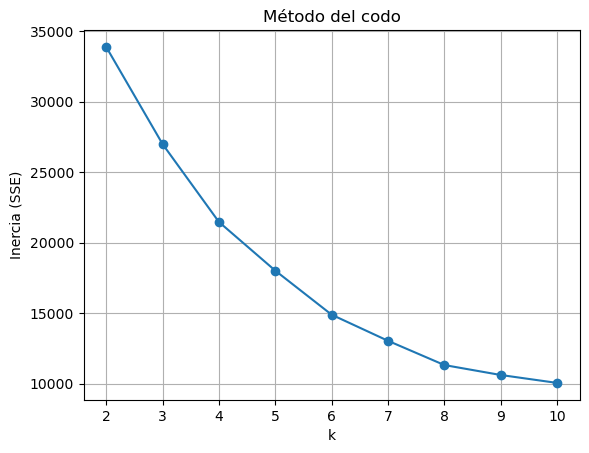

Inercia final: 14885.53  | Silhouette final: 0.2899


In [4]:


k_vals = range(2, 11)  # simple y suficiente
rows = []
for k in k_vals:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    rows.append((k, km.inertia_, silhouette_score(X_scaled, labels)))

resultados = pd.DataFrame(rows, columns=["k","SSE_inercia","Silhouette"])
display(resultados.sort_values("Silhouette", ascending=False))

# k recomendado = mejor silhouette
k_final = int(resultados.loc[resultados["Silhouette"].idxmax(), "k"])
print("k_final:", k_final)

# ÚNICO gráfico: método del codo
plt.plot(resultados["k"], resultados["SSE_inercia"], marker="o")
plt.xlabel("k"); plt.ylabel("Inercia (SSE)"); plt.title("Método del codo")
plt.grid(True); plt.show()

# Modelo final y etiquetas
kmeans = KMeans(n_clusters=k_final, init="k-means++", n_init=10, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Guarda 2 números para el informe
inercia_final = kmeans.inertia_
sil_final = silhouette_score(X_scaled, df["cluster"])
print("Inercia final:", round(inercia_final,2), " | Silhouette final:", round(sil_final,4))


In [5]:
perfiles = (
    df.groupby("cluster")[["Age","Annual Income","Spending Score"]]
      .mean()
      .round(1)
      .rename(columns={
          "Age": "Edad_prom",
          "Annual Income": "Ingreso_prom",
          "Spending Score": "Score_prom"
      })
)
perfiles["n_clientes"] = df["cluster"].value_counts().sort_index()
display(perfiles)

# También muestra tamaños por clúster (texto simple)
print("Tamaños por clúster:")
print(df["cluster"].value_counts().sort_index().to_string())


,Edad_prom,Ingreso_prom,Score_prom,n_clientes
cluster,,,,
0,74.5,80705.3,25.1,2505
1,45.9,160990.6,22.4,2427
2,34.1,142626.3,76.3,2412
3,60.3,59829.6,78.6,2606
4,74.4,155183.7,66.0,2574
5,34.6,63619.8,34.0,2555


Tamaños por clúster:
cluster
0    2505
1    2427
2    2412
3    2606
4    2574
5    2555
